In [1]:
import numpy as np
import open3d as o3d
import copy
import random
from matplotlib import pyplot as plt
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
#matplotlib notebook

##draw labels on the point cloud
def draw_labels_on_model(pcl,labels):
    cmap = plt.get_cmap("tab20")
    pcl_temp = copy.deepcopy(pcl)
    max_label = labels.max()
    colors = cmap(labels / (max_label if max_label > 0 else 1))
    pcl_temp.colors = o3d.utility.Vector3dVector(colors[:,:3])
    o3d.visualization.draw_geometries([pcl_temp])

d = 4
mesh = o3d.geometry.TriangleMesh.create_tetrahedron().translate((-d, 0, 0))
mesh += o3d.geometry.TriangleMesh.create_octahedron().translate((0, 0, 0))
mesh += o3d.geometry.TriangleMesh.create_icosahedron().translate((d, 0, 0))
mesh += o3d.geometry.TriangleMesh.create_torus().translate((-d, -d, 0))
mesh += o3d.geometry.TriangleMesh.create_moebius(twists=1).translate((0, -d, 0))
mesh += o3d.geometry.TriangleMesh.create_moebius(twists=2).translate((d, -d, 0))

##apply k means on this point cloud
point_cloud = mesh.sample_points_uniformly(int(1e5))
##transfer point cloud into array
xyz = np.asarray(point_cloud.points)

##define several necessary methods here
#normalize the dataset
def normalize(X,axis=-1,p=2):
    #normalize the array and then transfer into a vector
    lp_norm = np.atleast_1d(np.linalg.norm(X,p,axis))
    lp_norm[lp_norm == 0] = 1
    #expand a dimension along axis for lp_norm
    #this is to make sure X and lp_norm have the same dimensions
    return X / np.expand_dims(lp_norm,axis)

def euclidean_distance(one_sample,X):
    #transfer one_sample into 1D vector
    one_sample = one_sample.reshape(1,-1)
    #transfer X into 1D vector
    X = X.reshape(X.shape[0],-1)
    #this is used to make sure one_sample's dimension is same as X
    distances = np.power(np.tile(one_sample,(X.shape[0],1))-X,2).sum(axis=1)
    return distances

class Kmeans():
    #constructor
    def __init__(self,k=2,max_iterations=1500,tolerance=0.00001):
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
    
    #randomly select k centroids
    def init_random_centroids(self,X):
        #save the shape of X
        n_samples, n_features = np.shape(X)
        #make a zero matrix to store values
        centroids = np.zeros((self.k,n_features))
        #bcs there is k centroids, so we loop k tiems
        for i in range(self.k):
            #selecting values under the range radomly
            centroid = X[np.random.choice(range(n_samples))]
            centroids[i] = centroid
        return centroids

    #find the closest centroid of a sample
    def closest_centroid(self,sample,centroids):
        distances = euclidean_distance(sample,centroids)
        #np.argmin return the indices of the minimum of distances
        closest_i = np.argmin(distances)
        return closest_i

    #determine the clusers
    def create_clusters(self,centroids,X):
        n_samples = np.shape(X)[0]
        #This is to construct the nested list for storing clusters
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            centroid_i = self.closest_centroid(sample,centroids)
            clusters[centroid_i].append(sample_i)
        return clusters

    #update the centroids based on mean algorithm
    def update_centroids(self,clusters,X):
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.k,n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster],axis=0)
            centroids[i] = centroid
        self.cluster_centers_ = centroids
        return centroids

    #obtain the labels
    #same cluster, same y_pred value
    def get_cluster_labels(self,clusters,X):
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred

    #predict the labels
    def predict(self,X):
        #selecting the centroids randomly
        centroids = self.init_random_centroids(X)

        for _ in range(self.max_iterations):
            #clustering all the data point
            clusters = self.create_clusters(centroids,X)
            former_centroids = centroids
            #calculate new cluster center
            centroids = self.update_centroids(clusters,X)
            #judge the current difference if it meets convergence  
            diff = centroids - former_centroids
            if diff.any() < self.tolerance:
                break
            
        return self.get_cluster_labels(clusters,X) 

if __name__ == "__main__":

    clf = Kmeans(k=6)
    labels = clf.predict(xyz)
    
    draw_labels_on_model(point_cloud,labels)

In [ ]:
from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# 2 Elbow method to find the best K value
K = range(1, 10)
mean_distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter = 1500, tol = 0.00001)
    kmeans.fit(xyz)
    mean_distortions.append(
        sum(
            np.min(
                cdist(xyz, kmeans.cluster_centers_, metric='euclidean'), axis=1))
        / xyz.shape[0])
plt.plot(K, mean_distortions, 'bx-')
plt.xlabel('k')
font = FontProperties(fname=r'c:\windows\fonts\msyh.ttc')
plt.ylabel (u'average degree of distortion ', fontproperties = font)
plt.title (u'Use elbow method to determine the best K value ', fontproperties = font)
plt.show()

Silhouette

For n_clusters = 2 The average silhouette_score is : 0.5772273932678496
For n_clusters = 3 The average silhouette_score is : 0.4678194200109377
For n_clusters = 4 The average silhouette_score is : 0.5144285045856022
For n_clusters = 5 The average silhouette_score is : 0.5137261129598686
For n_clusters = 6 The average silhouette_score is : 0.41572094317052966


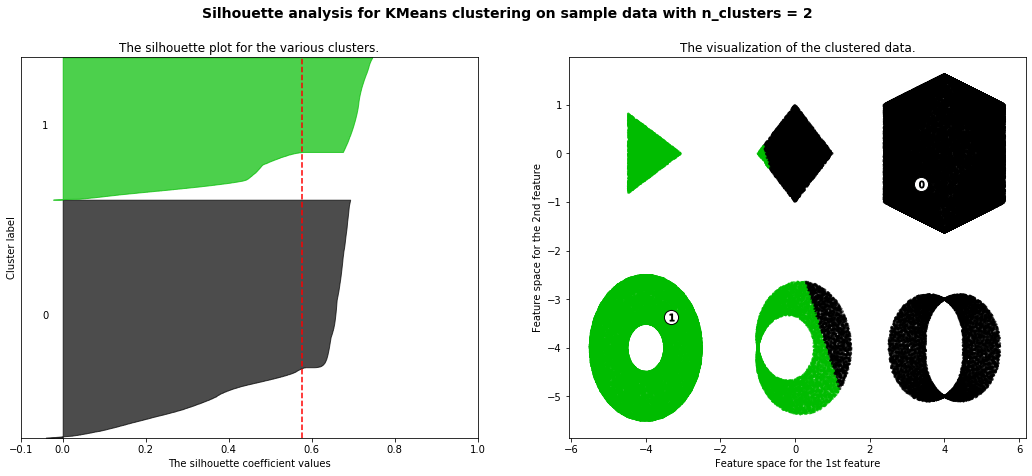

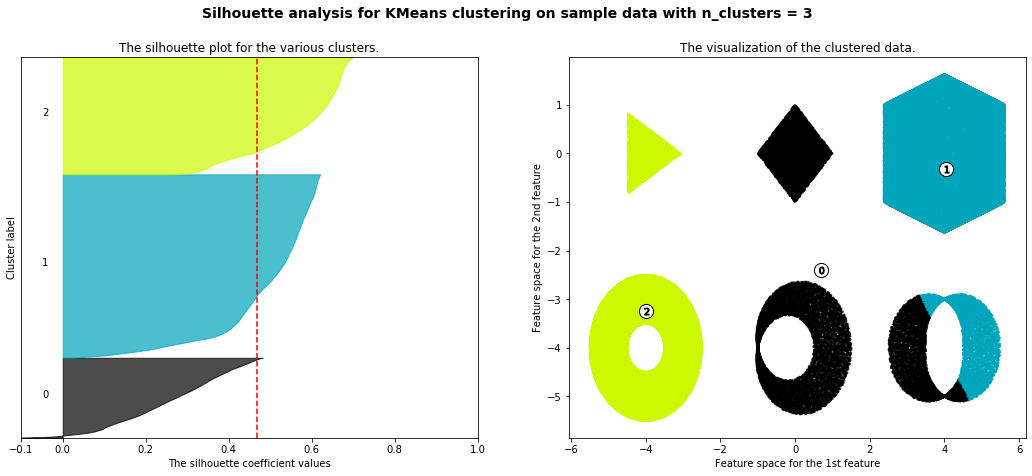

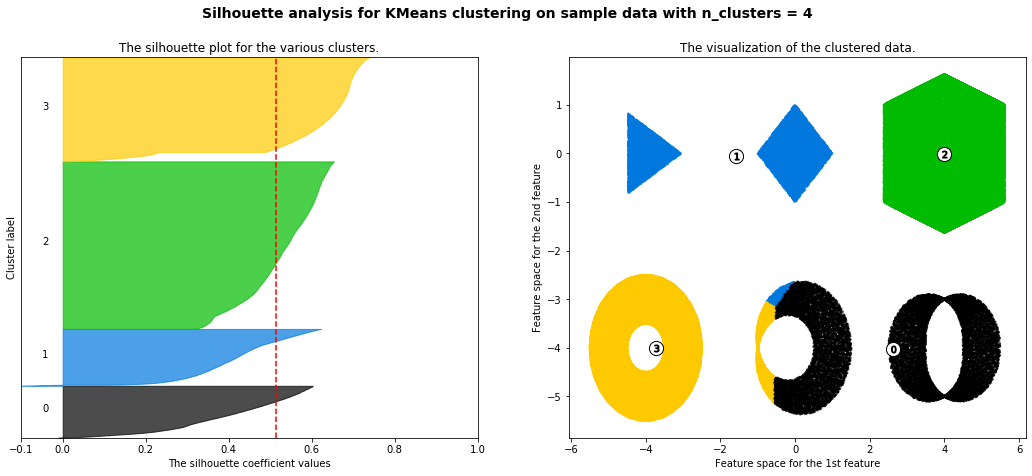

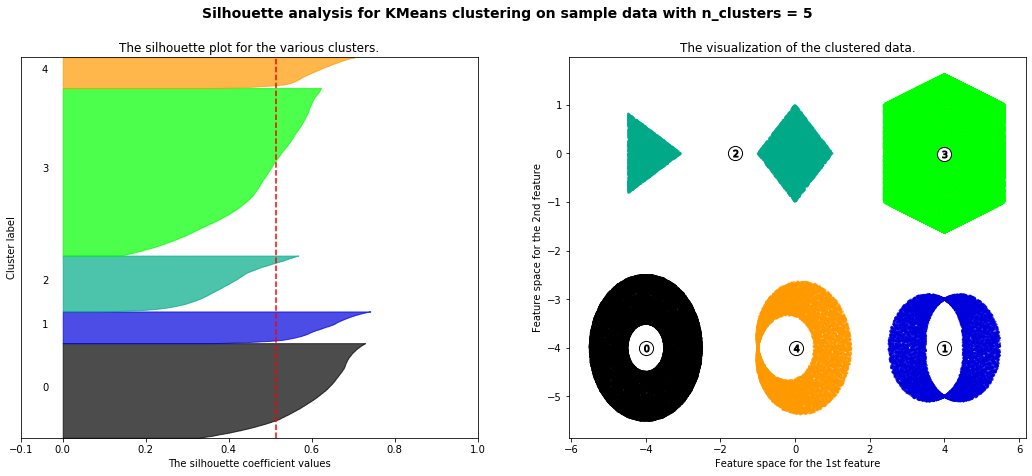

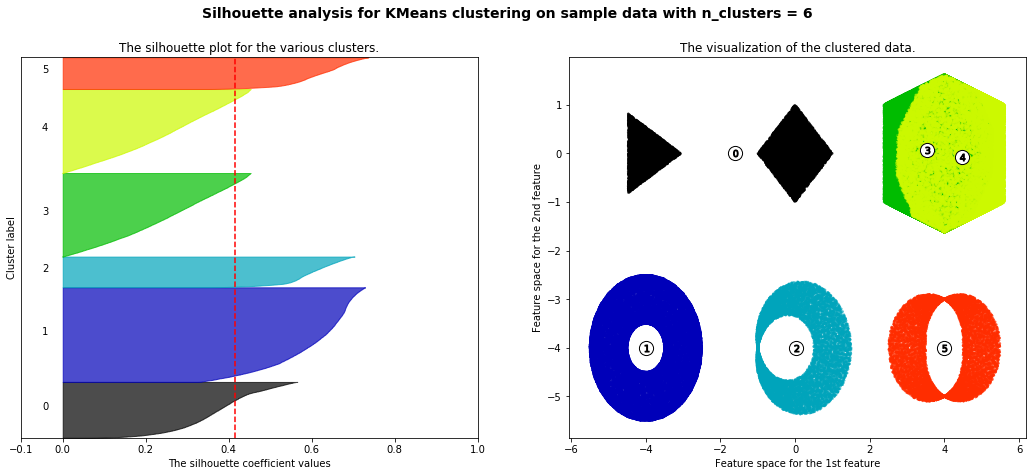

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(xyz) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

#     clusterer = KMeans(n_clusters=k, max_iter = 1500, tol = 0.00001)
#     cluster_labels = clusterer.fit_predict(xyz)
    clusterer = Kmeans(n_clusters)
    cluster_labels = clusterer.predict(xyz)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(xyz, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(xyz, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(xyz[:, 0], xyz[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()